In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
import torchvision.models as models
from PIL import Image

In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-75482a68-87db-0388-ad83-12be720efe26)


In [ ]:
from scripts.serverside.captcha.image import ImageCaptcha
from tqdm import tqdm
import os
import string
import random
import gc

In [ ]:
def get_random_string(length):
    # choose from all lowercase letter
    letters = "abcdefghjkmnpqrstuvwxyz" + "ABCDEFGHIJKLMNPQRSTUVWXYZ" + "23456789" + "     "
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

In [ ]:
from torchvision.transforms.transforms import Grayscale
# Load datasets
# Label formated as 2D tensor of indexed as [place][tokenID]
chars = "abcdefghijklmnpqrstuvwxyz123456789 " # use " " as null character. Leave out o and 0, also case insensitive
charIndex = {}
for i, char in enumerate(chars):
    charIndex[char] = i

idn = torch.eye(len(chars)).cuda()

def strToOH(string):
    oneHot = []
    for char in string:
      oneHot.append(idn[charIndex[char]])
    return torch.stack(oneHot)

def strToInd(string):
    oneHot = []
    for char in string:
      oneHot.append(torch.tensor(charIndex[char]))
    return torch.stack(oneHot)

In [ ]:
do_cuda = True
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="max_split_size_mb:128"
torch.cuda.empty_cache()

In [ ]:
def get_accuracy(model, data_loader=None, denoise=False, train=False, batch_size = 64):
    if train:
        data = captchaPreProcLarge
    else:
        data = TrawSetVal #TODO: seperate validation set

    correct = 0
    total = 0
    if data_loader is None:
      data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    for imgs, labels, filtered in data_loader :

        if do_cuda and torch.cuda.is_available:
            imgs = imgs.cuda()
            labels = labels.cuda()
            filtered = filtered.cuda()

        if denoise:
          output = model(filtered)
        else:
          output = model(imgs, filtered)
        for i in range(imgs.shape[0]):
            #select index with maximum prediction score
            out = output[i, :, :]
            #print(out.shape)
            #print(digit.shape)
            pred = out.max(0, keepdim=True)[1]
            pred = pred.squeeze()
            #print(pred.shape)
            #print(labels[:, i].shape)
            #print(labels[i, :].shape)
            #print(pred.shape)
            correct += int(pred.eq(labels[i, :]).sum().item() == 8)
            total += 1
    torch.cuda.empty_cache()
    gc.collect()
    return correct / total

def train(model, data, batch_size=64, num_epochs=30, from_epoch=0, learning_rate=0.0001):
  #  train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    train_loader = None
    val_loader = torch.utils.data.DataLoader(TrawSetVal, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []


    startTime = time.time() # to see how long training goes
    print("starting training")
    # training
    n = 0 # the number of iterations
    for epoch in range(from_epoch, from_epoch+num_epochs):
        
        try:
            del train_loader
            torch.cuda.empty_cache()
            gc.collect()
            data.flush()
            train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        except Exception:
            pass
        print("epoch: ", epoch)
        for imgs, labels, filtered in iter(train_loader):

            if do_cuda and torch.cuda.is_available:
              imgs = imgs.cuda()
              labels = labels.cuda()
              filtered = filtered.cuda()

            out = model(imgs, filtered)             # forward pass
            #print(out[0])
            #print()
            #print(labels[0])
            #print()
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(loss.item()/batch_size)             # compute *average* loss
            n += 1

        #train_acc.append(get_accuracy(model, train=True, batch_size=batch_size)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_loader, train=False, batch_size=batch_size))  # compute validation accuracy
        print(("Epoch {}: |"+"Validation acc: {}").format(
                epoch, # call epoch zero epoch zero
                
                val_acc[-1]))
        
        #checkpoint
        path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
        torch.save(model.state_dict(), path)


    np.savetxt(path+f"/tacc_{from_epoch+1}_to_{from_epoch+num_epochs}.csv", 
                val_acc,
                delimiter =", ", 
                fmt ='% s')
    
    finishTime = time.time()

    delta = finishTime - startTime
    print("\nDONE TRAINING in %s seconds!\n" % delta)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.savefig(f"/loss_e{from_epoch+num_epochs}_{path}.jpg")

    plt.figure()
    plt.title("Training Curve")
    #plt.plot(range(num_epochs), train_acc, label="Train")
    plt.plot(range(num_epochs), val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.savefig(f"/acc_e{from_epoch+num_epochs}_{path}_{val_acc[-1]}.jpg")

    #print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
class DemoFrozenSet():
    def __init__(self, size):
        self.size = size
        self.cached = []
        self.period = size
        self.IC = ImageCaptcha()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.flush2()
    def flush2(self):
        self.cached.clear()
        for index in tqdm(range(self.period)):
            label = get_random_string(8)
            data = self.IC.generate_image(label)
            data2 = run_denoiser.execute_pix2pix_denoise(global_denoising, copy.deepcopy(data))
            data = self.transform(data)
            data2 = self.transform(data2)
            label = label.lower().replace(" ", "")
            label += " " * (8 - len(label))

            labelTensor = strToInd(label)
            self.cached.append((data, labelTensor, data2))
    def __getitem__(self, index):
        index = index % self.period
        entry = self.cached[index]
        return entry[0], entry[1], entry[2]

    def __len__(self):
        return self.size

In [ ]:
class ECaptcha2(nn.Module):
    def __init__(self):
        super(ECaptcha2, self).__init__()
        self.name = "ETransferCaptcha2"
        self.VIT = ViTCaptcha()
        self.CONV = TransferCaptcha()
        self.VIT2 = ViTCaptcha()
        self.CONV2 = TransferCaptcha()
        self.VIT.requires_grad = False
        self.CONV.requires_grad = False
        self.VIT2.requires_grad = False
        self.CONV2.requires_grad = False

        self.ensembler = nn.Linear(len(chars) * 8 * 4, len(chars) * 8)
    def forward(self, x, x2):
        with torch.no_grad():
          pre1 = self.VIT(x.clone()).view(-1, len(chars) * 8)
          pre2 = self.CONV(x.clone()).view(-1, len(chars) * 8)

          pre3 = self.VIT2(x2.clone()).view(-1, len(chars) * 8)
          pre4 = self.CONV2(x2.clone()).view(-1, len(chars) * 8)
        x = torch.cat((pre1, pre2, pre3, pre4), 1)
        x = self.ensembler(x)
        x = x.view(-1, len(chars), 8)
        #x = x.squeeze(1) # Flatten to [batch_size]
        return x  

In [ ]:
model2 = ECaptcha2()

In [ ]:
import run_denoiser
global_denoising = run_denoiser.load_pix2pix_CAPTCHA()

initialize network with normal


In [ ]:
random.seed(1)
torch.manual_seed(1)
TrawSetVal = DFrozenSet(250)

In [ ]:
print("CONV ACC:",  get_accuracy(model2.CONV))
print("VIT ACC:",  get_accuracy(model2.VIT))
print("DENOISED CONV ACC:",  get_accuracy(model2.CONV2, denoise=True))
print("DENOISED VIT ACC:",  get_accuracy(model2.VIT2, denoise=True))

CONV ACC: 0.56
VIT ACC: 0.588
DENOISED CONV ACC: 0.692
DENOISED VIT ACC: 0.752


### Demo code

In [ ]:
model2 = ECaptcha2()
model2.load_state_dict(torch.load("model_ETransferCaptcha2_bs128_lr0.0005_epoch200_836"))

<All keys matched successfully>

In [ ]:
print("Generating images...")
demo_set = DFrozenSet(5)

Generating images...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 50.13it/s]


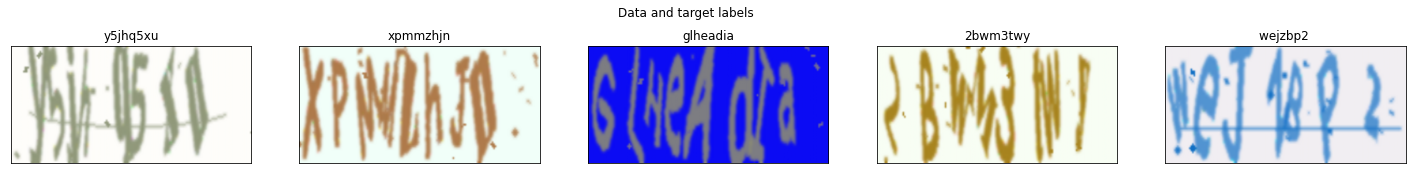

In [ ]:
fig = plt.figure(figsize=(25, 5))
fig.suptitle("Data and target labels")
for i in range(len(demo_set)):
  data, label, denoised = demo_set[i]
  show = transforms.Resize((224, 460))(data.cpu())
  ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(show,(1, 2, 0)))
  ax.set_title("".join([chars[int(i)] for i in label]))

In [ ]:
demo_loader = torch.utils.data.DataLoader(demo_set, batch_size=5)
data, label, denoised = iter(demo_loader).next()
out = model2(data, denoised)
pred = out.max(1, keepdim=True)[1]
print("  Prediction   |    Target    |  Correct? \n", "-"*45)
for idx, enc in enumerate(pred):
  print(" "*2, "".join([chars[int(i)] for i in enc.flatten()]),  \
        " "*6, "".join([chars[int(a)] for a in demo_set[idx][1]]),\
        " "*6, bool(torch.all(enc.flatten().eq(demo_set[idx][1]))))

  Prediction   |    Target    |  Correct? 
 ---------------------------------------------
   y5jhq5xu        y5jhq5xu        True
   xpnnzhjn        xpmmzhjn        False
   glheadia        glheadia        True
   2bwm3twy        2bwm3twy        True
   wej2bp2         wejzbp2         False
